Titanic: data information

Pclass Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
survival Survival (0 = No; 1 = Yes)
name Name
sex Sex
age Age
sibsp Number of Siblings/Spouses Aboard
parch Number of Parents/Children Aboard
ticket Ticket Number
fare Passenger Fare (British pound)
cabin Cabin
embarked Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
boat Lifeboat
body Body Identification Number
home.dest Home/Destination

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
import pandas as pd
import os

# show all rows in a DF
def printall(X, max_rows = 20):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows = max_rows)))


os.chdir('/Users/talbotm/Dropbox/python_working_files/titanic')
print(os.getcwd())

X = pd.read_csv('titanic.csv')
y = X.pop('survived')
y = y.astype('int32')
print(X.columns)

/Users/talbotm/Dropbox/python_working_files/titanic
Index(['pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare',
       'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')


In [2]:
# last value is NaN for all cols
X = X[0:1309]
y = y[0:1309]
X.pop('body')
X.pop('ticket')
X.pop('boat')
X.describe()

,pclass,age,sibsp,parch,fare
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,29.881135,0.498854,0.385027,33.295479
std,0.837836,14.413500,1.041658,0.865560,51.758668
min,1.000000,0.166700,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,80.000000,8.000000,9.000000,512.329200


In [3]:
numeric_var = list(X.dtypes[X.dtypes != "object"].index)
numeric_var =  numeric_var[1:]
categorical_var = list(X.dtypes[X.dtypes == "object"].index)
categorical_var.append('pclass')


for i in X[numeric_var]:
    X[i].fillna(X[i].mean(), inplace = True)
X[numeric_var].describe()  

,age,sibsp,parch,fare
count,1309.000000,1309.000000,1309.000000,1309.000000
mean,29.881135,0.498854,0.385027,33.295479
std,12.883199,1.041658,0.865560,51.738879
min,0.166700,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,7.895800
50%,29.881135,0.000000,0.000000,14.454200
75%,35.000000,1.000000,0.000000,31.275000
max,80.000000,8.000000,9.000000,512.329200


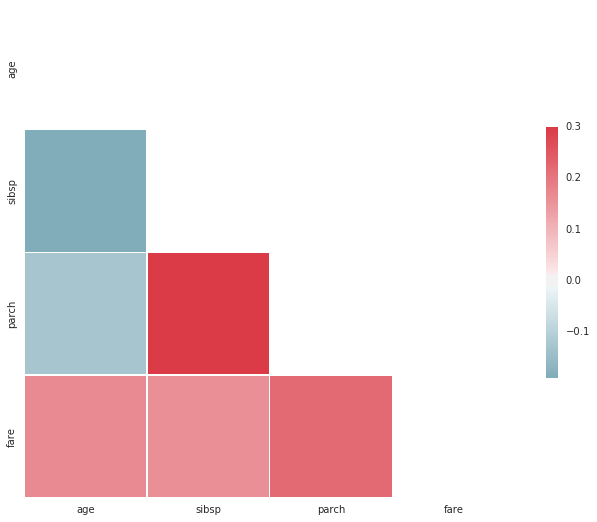

In [23]:
%matplotlib inline  

def cor_matrix_graph(d):
    from string import ascii_letters
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set(style="white")

    # Compute the correlation matrix
    corr = d.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
cor_matrix_graph(X[numeric_var])

In [5]:
# a quick performance check
model = RandomForestRegressor(n_estimators = 100,  oob_score = True, random_state = 42)
model.fit(X[numeric_var], y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [6]:
r_sqr = model.oob_score_
roc = roc_auc_score(y, model.oob_prediction_)
print("benchmark accuracy = {0:0.3f}%".format(roc*100))

benchmark accuracy = 70.086%


In [7]:
### FEATURE ENGINEERING
# working on categorical variables
X[categorical_var].describe()
# removing names but keeping titles 
X.name = [ str[str.find(',')+2: str.find('.')] for str in X.name ]
# only preserving cabin's first letter, put ? when NaN
X.cabin.fillna('?', inplace=True)
X.cabin = [ X.cabin[i][0] for i in range(0, X.cabin.shape[0])]
# preserve state or last two letters, put ? when NaN
X['home.dest'].fillna(', ?', inplace = True)
X['home.dest'] = [str[len(str)-2 :] for str in X['home.dest']]
# put a ? 
X['embarked'].fillna('?', inplace = True)


In [8]:
X[categorical_var].count()

name         1309
sex          1309
cabin        1309
embarked     1309
home.dest    1309
pclass       1309
dtype: int64

In [9]:
X[numeric_var].count()

age      1309
sibsp    1309
parch    1309
fare     1309
dtype: int64

In [10]:
for var in categorical_var:
    dummies = pd.get_dummies(X[var], prefix=var)
    X = pd.concat([X, dummies], axis=1)
    X.drop(var, axis =1, inplace = True)

In [11]:
model = RandomForestRegressor(n_estimators = 100,  oob_score = True, random_state = 42)
model.fit(X, y)

r_sqr = model.oob_score_
roc = roc_auc_score(y, model.oob_prediction_)
print("benchmark accuracy = {0:0.3f}%".format(roc*100))

benchmark accuracy = 85.802%


In [12]:
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(inplace=True)

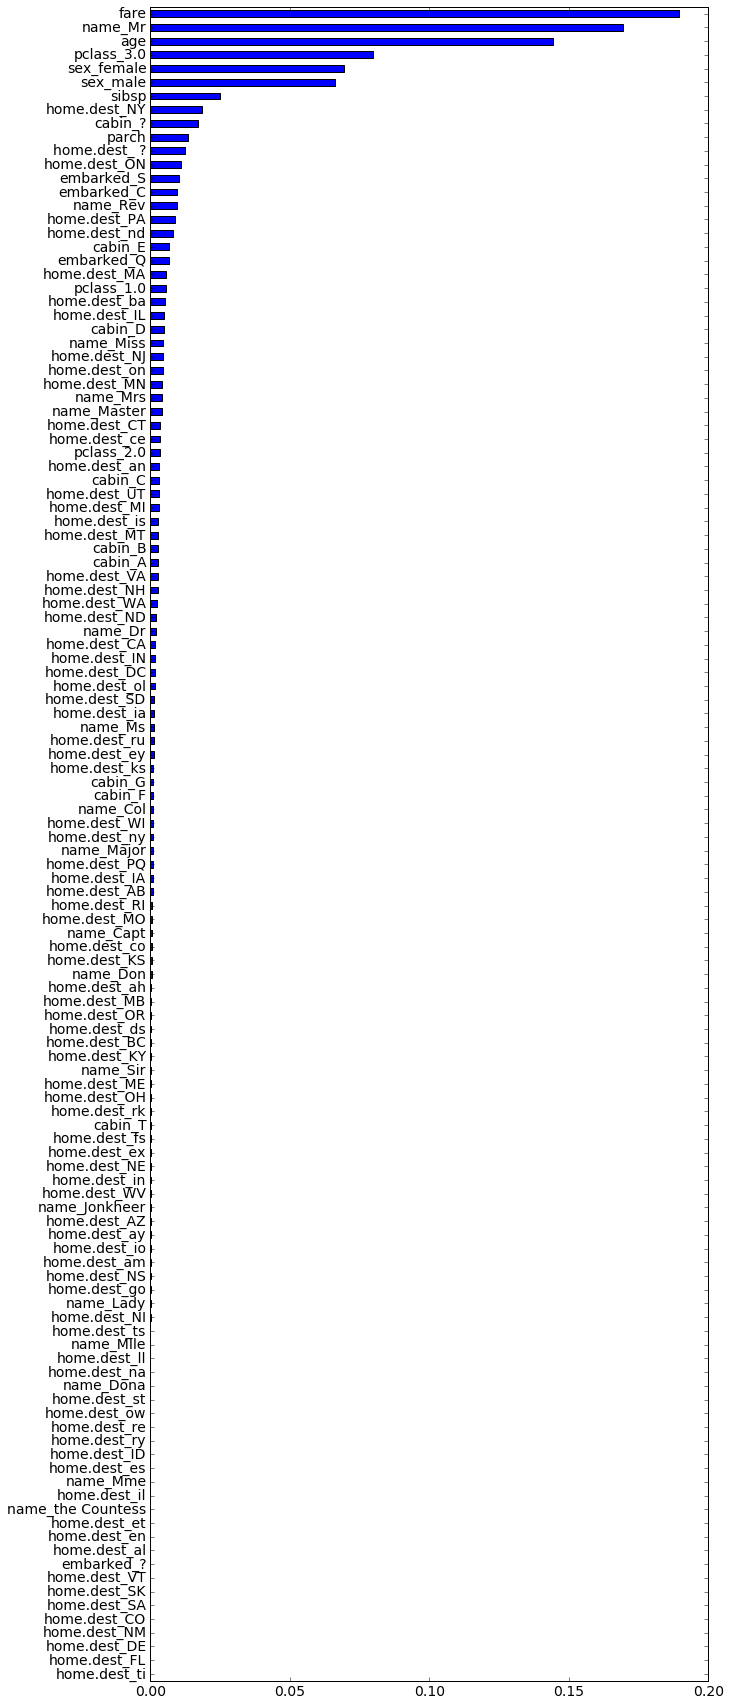

In [13]:
feature_importance.plot(kind='barh', figsize=[10,30], fontsize=14)

In [14]:
pd.Series(dict(zip(X.columns, model.feature_importances_)))

age                  0.144334
cabin_?              0.017147
cabin_A              0.002583
cabin_B              0.002630
cabin_C              0.003083
cabin_D              0.004964
cabin_E              0.006699
cabin_F              0.000937
cabin_G              0.000977
cabin_T              0.000167
embarked_?           0.000000
embarked_C           0.009356
embarked_Q           0.006498
embarked_S           0.010319
fare                 0.189271
home.dest_ ?         0.012480
home.dest_AB         0.000790
home.dest_AZ         0.000053
home.dest_BC         0.000255
home.dest_CA         0.001757
home.dest_CO         0.000000
home.dest_CT         0.003533
home.dest_DC         0.001586
home.dest_DE         0.000000
home.dest_FL         0.000000
home.dest_IA         0.000793
home.dest_ID         0.000000
home.dest_IL         0.004972
home.dest_IN         0.001643
home.dest_KS         0.000413
                       ...   
home.dest_ru         0.001138
home.dest_ry         0.000000
home.dest_

In [15]:
def graph_feature_importance(model, feature_names, summarized_columns = None):

    feature_dict = dict(zip(feature_names, model.feature_importances_))
    if summarized_columns:
        for col_name in summarized_columns:
            sum_value = sum(x for i, x in feature_dict.items() if col_name in i)
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i]
            for i in keys_to_remove:
                feature_dict.pop(i)
            feature_dict[col_name] = sum_value

    temp = pd.Series(feature_dict, index=feature_dict).sort_values()
    temp.plot(kind='barh', figsize=[10,5], fontsize=14)

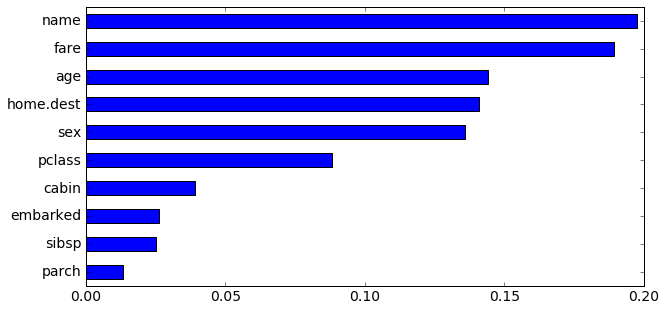

In [16]:
graph_feature_importance(model, X.columns, summarized_columns = categorical_var)

In [17]:
# removing parch, sibsp, embarked
# X.pop('embarked')
# X.pop('sibsp')
# X.pop('parch')
X.head()

,age,sibsp,parch,fare,name_Capt,name_Col,name_Don,name_Dona,name_Dr,name_Jonkheer,...,home.dest_re,home.dest_rk,home.dest_ru,home.dest_ry,home.dest_st,home.dest_ti,home.dest_ts,pclass_1.0,pclass_2.0,pclass_3.0
0,29.0000,0.0,0.0,211.3375,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.9167,1.0,2.0,151.5500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2.0000,1.0,2.0,151.5500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,30.0000,1.0,2.0,151.5500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,25.0000,1.0,2.0,151.5500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [55]:
model = RandomForestRegressor(n_estimators = 100,  oob_score = True, random_state = 42)
model.fit(X, y)

r_sqr = model.oob_score_
roc = roc_auc_score(y, model.oob_prediction_)
print("benchmark accuracy = {0:0.3f}%".format(roc*100))

benchmark accuracy = 85.802%


In [19]:
categorical_var.remove('embarked')
categorical_var.remove('sibsp')
categorical_var.remove('parch')

ValueError: list.remove(x): x not in list

In [59]:
#fine tuning hyper parameters with cross-val
from sklearn.model_selection import GridSearchCV


# define the parameter values that should be searched
results = []
n_estimator_list = list(range(100, 1250, 250))
max_feature_list = ['auto', None, 'sqrt', 'log2'] # number of variables used
min_sample_leaf_list = list(range(1,3))

param_grid = dict(n_estimators=n_estimator_list, max_features = max_feature_list, min_samples_leaf = min_sample_leaf_list)
print(param_grid)

{'max_features': ['auto', None, 'sqrt', 'log2'], 'min_samples_leaf': [1, 2], 'n_estimators': [100, 350, 600, 850, 1100]}


In [63]:
model = RandomForestRegressor(n_estimators = 100,  oob_score = True, random_state = 42)
grid = GridSearchCV(model, param_grid,  cv=5, n_jobs=-1)

grid.fit(X, y)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': ['auto', None, 'sqrt', 'log2'], 'min_samples_leaf': [1, 2], 'n_estimators': [100, 350, 600, 850, 1100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [69]:

print(grid.best_score_)
print(grid.best_params_)

0.31484753365
{'max_features': 'sqrt', 'n_estimators': 350, 'min_samples_leaf': 2}


In [70]:
model = RandomForestRegressor(max_features= 'sqrt', n_estimators = 350,  min_samples_leaf= 2, oob_score = True, random_state = 42)
model.fit(X, y)

r_sqr = model.oob_score_
roc = roc_auc_score(y, model.oob_prediction_)
print("benchmark accuracy = {0:0.3f}%".format(roc*100))

benchmark accuracy = 86.839%
